# Test on Image

shape......................... (480, 852, 3)
['dog', 'person', 'cat', 'tv', 'car', 'meatballs', 'marinara sauce', 'tomato soup', 'chicken noodle soup', 'french onion soup', 'chicken breast', 'ribs', 'pulled pork', 'hamburger', 'cavity', 'person_no_phone', 'person_phone_hand', 'person_phone_head']
height.................. 480
net............. <dnn_Net 000001F1BAFE6650>
crds-------> 489 365 65.5 98.5
indices...... [[0]]
16
person_phone_hand


-1

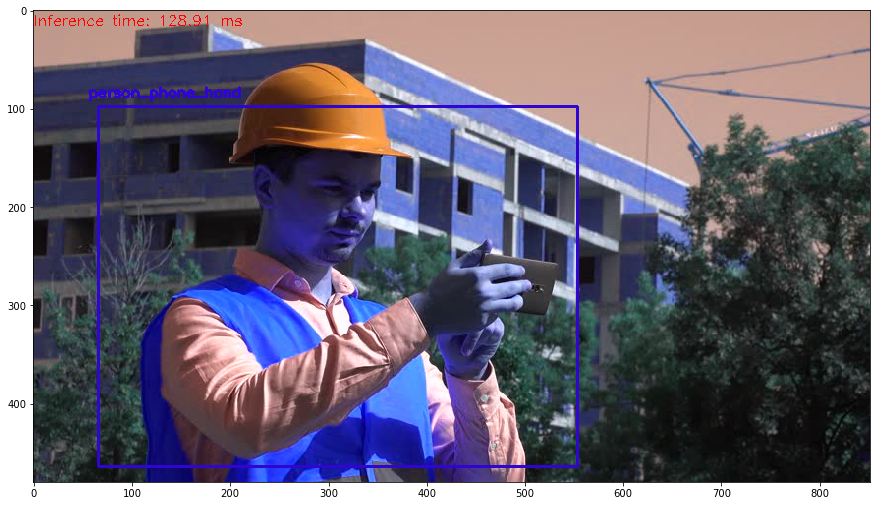

In [4]:
import cv2
import matplotlib.pyplot as plt
import argparse
import numpy as np

ap = argparse.ArgumentParser()
args = {
        "config": './yolov3-tiny.cfg',
        "weights": './yolov3-tiny_best_24k.weights',
        "classes": './object.names'
        }


def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]


# Darw a rectangle surrounding the object and its class name 
def draw_pred(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])
#     ####save cropped persons
#     if label == 'person':
#         ROI = image[y:y_plus_h, x:x_plus_w]
#         cv2.imwrite('./persons/ROI_{}.png'.format(i), ROI)
    print(label)
    color = COLORS[class_id]
#     color = (255,255,255)

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)
    
image = cv2.imread('C:/Users/TR1174/Desktop/Final Datasets/full_frame_ds/Final_DS/hand_001.jpg')
image = adjust_gamma(image, gamma = 1.0)


# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image)
print('shape.........................', image.shape)
#plt.imshow(image)
classes = None
with open(args['classes'], 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# Define network from configuration file and load the weights from the given weights file
net = cv2.dnn.readNet(args['weights'],args['config'])

blob = cv2.dnn.blobFromImage(image, 1.0/255.0, (416,416), [0,0,0], True, crop=False) ###(416,416)

print('height..................',image.shape[0])
Width = image.shape[1]
Height = image.shape[0]
net.setInput(blob)
print('net.............', net)
outs = net.forward(getOutputsNames(net))
#print('outs.........................................',outs)

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5 ##################################0.5
nms_threshold =  0.4##################################0.4


#print(len(outs))

# In case of tiny YOLOv3 we have 2 output(outs) from 2 different scales [3 bounding box per each scale]
# For normal normal YOLOv3 we have 3 output(outs) from 3 different scales [3 bounding box per each scale]

# For tiny YOLOv3, the first output will be 507x6 = 13x13x18
# 18=3*(4+1+1) 4 boundingbox offsets, 1 objectness prediction, and 1 class score.
# and the second output will be = 2028x6=26x26x18 (18=3*6) 

for out in outs: 
    #print(out.shape)
    for i,detection in zip(range(len(out)),out):
        #print('detection....................',detection)
    #each detection  has the form like this [center_x center_y width height obj_score class_1_score class_2_score ..]
        scores = detection[5:]#classes scores starts from index 5
        #print(scores)
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence >= 0.5:###############################0.5:
            #print(detection[0], Width)
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            print('crds------->',w,h,x,y)
#             ROI = image[int(y):int(y+h), int(x):int(x+w)]
# #             print(detection.index)
#             cv2.imwrite('./cropped/ROI_{}.png'.format(i), ROI)
            
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])
#print(boxes)
# apply  non-maximum suppression algorithm on the bounding boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
print('indices......',indices)

for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    print(class_ids[i])
    draw_pred(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
    
#     ROI = image[int(y):int(y+h), int(x):int(x+w)]
# #             print(detection.index)
#     cv2.imwrite('./cropped/ROI_{}.png'.format(i), ROI)

# Put efficiency information.
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(image, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))

cv2.imwrite("Image.png", image)
plt.figure(figsize=(15,15))
plt.imshow(image)
cv2.waitKey(0)


# Test  on Video

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

import time
import cv2
import argparse
import numpy as np

ap = argparse.ArgumentParser()
args = {
        "config": './yolov3-tiny.cfg',
        "weights": './yolov3-tiny_best_1.weights',
        "classes": './object.names'
        }
#args = ap.parse_args()


# Get names of output layers, output for YOLOv3 is ['yolo_16', 'yolo_23']
def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]


# Darw a rectangle surrounding the object and its class name 
def draw_pred(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])
    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Define a window to show the cam stream on it
window_title= "Cellphone Detector"   
cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)


# Load names classes
classes = None
with open(args['classes'], 'r') as f:
    classes = [line.strip() for line in f.readlines()]


#Generate color for each class randomly
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# Define network from configuration file and load the weights from the given weights file
net = cv2.dnn.readNet(args['weights'],args['config'])

# Define video capture for default cam
cap = cv2.VideoCapture('C:/Users/TR1174/Desktop/CCTV PD/Training Videos/Man_Welding_on_Roof_1.mov')

def adjust_gamma(image, gamma=1):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255for i in np.arange(0, 256)]).astype("uint8")
   # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


while cv2.waitKey(1) < 0:
#     print(cap.read()[0])
#     print(time.time())
    hasframe, image = cap.read()
  #image=cv2.resize(image, (1920, 416))
    image = adjust_gamma(image, gamma=1)
#     image = cv2.transpose(image, image)

    blob = cv2.dnn.blobFromImage(image, 1.0/255.0, (416,416), [0,0,0], True, crop=False)
    Width = image.shape[1]
    Height = image.shape[0]
    net.setInput(blob)

    outs = net.forward(getOutputsNames(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.2
    nms_threshold = 0.1


    #print(len(outs))

    # In case of tiny YOLOv3 we have 2 output(outs) from 2 different scales [3 bounding box per each scale]
    # For normal normal YOLOv3 we have 3 output(outs) from 3 different scales [3 bounding box per each scale]

    # For tiny YOLOv3, the first output will be 507x6 = 13x13x18
    # 18=3*(4+1+1) 4 boundingbox offsets, 1 objectness prediction, and 1 class score.
    # and the second output will be = 2028x6=26x26x18 (18=3*6) 

    for out in outs: 
        #print(out.shape)
        for detection in out:
            #print(detection)

        #each detection  has the form like this [center_x center_y width height obj_score class_1_score class_2_score ..]
            scores = detection[5:]#classes scores starts from index 5
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    # apply  non-maximum suppression algorithm on the bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_pred(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), 
                   round(y+h))

    # Put efficiency information.
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(image, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))

    cv2.imshow(window_title, image)
    if cv2.waitKey(10) == 27:
        break
cap.release()
cv2.destroyAllWindows()


# Parsing bb images

In [37]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import cv2
import argparse
import numpy as np

ap = argparse.ArgumentParser()
args = {
        "config": './yolov3-spp_original.cfg',
        "weights": './yolov3-spp.weights',
        "classes": './coco.names'
        }
#args = ap.parse_args()


# Get names of output layers, output for YOLOv3 is ['yolo_16', 'yolo_23']
def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]


# Darw a rectangle surrounding the object and its class name 
def draw_pred(img, class_id, confidence, x, y, x_plus_w, y_plus_h, count, f_count):

    label = str(classes[class_id])
    # save roi's as .jpgs    
    if label == 'person' == 0:
        ROI = image[y:y_plus_h, x:x_plus_w]
#         cv2.imwrite('./persons/ROI_{:04}.jpg'.format(count), ROI)
#         count += 1
        color = COLORS[class_id]

        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

        cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Define a window to show the cam stream on it
window_title= "Cellphone Detector"   
cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)


# Load names classes
classes = None
with open(args['classes'], 'r') as f:
    classes = [line.strip() for line in f.readlines()]


#Generate color for each class randomly
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# Define network from configuration file and load the weights from the given weights file
net = cv2.dnn.readNet(args['weights'],args['config'])

# Define video capture for default cam
cap = cv2.VideoCapture('C:/Users/TR1174/Desktop/CCTV PD/Training Videos/Man_Welding_on_Roof_1.mov')

def adjust_gamma(image, gamma=1):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255for i in np.arange(0, 256)]).astype("uint8")
   # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

count = 0
f_count = 0
while cv2.waitKey(1) < 0:
    hasframe, image = cap.read()
    f_count += 1
    #image=cv2.resize(image, (1920, 416))
    image = adjust_gamma(image, gamma=1)
#     image = cv2.transpose(image, image)

    blob = cv2.dnn.blobFromImage(image, 1.0/255.0, (608,608), [0,0,0], True, crop=False)
    Width = image.shape[1]
    Height = image.shape[0]
    net.setInput(blob)

    outs = net.forward(getOutputsNames(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    #print(len(outs))

    # In case of tiny YOLOv3 we have 2 output(outs) from 2 different scales [3 bounding box per each scale]
    # For normal normal YOLOv3 we have 3 output(outs) from 3 different scales [3 bounding box per each scale]

    # For tiny YOLOv3, the first output will be 507x6 = 13x13x18
    # 18=3*(4+1+1) 4 boundingbox offsets, 1 objectness prediction, and 1 class score.
    # and the second output will be = 2028x6=26x26x18 (18=3*6) 

    for out in outs: 
        #print(out.shape)
        for detection in out:
            #print(detection)

        #each detection  has the form like this [center_x center_y width height obj_score class_1_score class_2_score ..]
            scores = detection[5:]#classes scores starts from index 5
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    # apply  non-maximum suppression algorithm on the bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        count += 1
        draw_pred(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), 
                   round(y+h), count, f_count)

    # Put efficiency information.
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(image, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))

    cv2.imshow(window_title, image)
    if cv2.waitKey(10) == 27:
        break
cap.release()
cv2.destroyAllWindows()


# Parsing bb folder

In [1]:
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import numpy as np

ap = argparse.ArgumentParser()
args = {
        "config": './yolov3-spp_original.cfg',
        "weights": './yolov3-spp.weights',
        "classes": './coco.names'
        }
#args = ap.parse_args()


# Get names of output layers, output for YOLOv3 is ['yolo_16', 'yolo_23']
def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]


# Darw a rectangle surrounding the object and its class name 
def draw_pred(img, class_id, confidence, x, y, x_plus_w, y_plus_h, count, f_count):

    label = str(classes[class_id])
    # save roi's as .jpgs    
    if label == 'person':
        ROI = image[y:y_plus_h, x:x_plus_w]
#         print(y, y_plus_h, x,x_plus_w)
#         print(ROI.shape)
#         plt.imshow(ROI)
        if ROI.shape[0] != 0 and ROI.shape[1] != 0 :
            cv2.imwrite('C:/Users/TR1174/Desktop/CCTV PD/Dataset/check_dataset/persons/ROI_{:04}.jpg'.format(count), ROI)
#         count += 1
        color = COLORS[class_id]

        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

        cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


# Load names classes
classes = None
with open(args['classes'], 'r') as f:
    classes = [line.strip() for line in f.readlines()]


#Generate color for each class randomly
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# Define network from configuration file and load the weights from the given weights file
net = cv2.dnn.readNet(args['weights'],args['config'])


def adjust_gamma(image, gamma=1):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255for i in np.arange(0, 256)]).astype("uint8")
   # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

count = 0
f_count = 0
path = 'C:/Users/TR1174/Desktop/CCTV PD/Dataset/check_dataset'
files = os.listdir(path)
files = files[2:]
for i in files:
    image = cv2.imread(path +'/'+ i)
    f_count += 1
    #image=cv2.resize(image, (1920, 416))
    image = adjust_gamma(image, gamma=1)
#     image = cv2.transpose(image, image)

    blob = cv2.dnn.blobFromImage(image, 1.0/255.0, (416,416), [0,0,0], True, crop=False)
    Width = image.shape[1]
    Height = image.shape[0]
    net.setInput(blob)

    outs = net.forward(getOutputsNames(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    #print(len(outs))

    # In case of tiny YOLOv3 we have 2 output(outs) from 2 different scales [3 bounding box per each scale]
    # For normal normal YOLOv3 we have 3 output(outs) from 3 different scales [3 bounding box per each scale]

    # For tiny YOLOv3, the first output will be 507x6 = 13x13x18
    # 18=3*(4+1+1) 4 boundingbox offsets, 1 objectness prediction, and 1 class score.
    # and the second output will be = 2028x6=26x26x18 (18=3*6) 

    for out in outs: 
        #print(out.shape)
        for detection in out:
            #print(detection)

        #each detection  has the form like this [center_x center_y width height obj_score class_1_score class_2_score ..]
            scores = detection[5:]#classes scores starts from index 5
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.4:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    # apply  non-maximum suppression algorithm on the bounding boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        count += 1
        draw_pred(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), 
                   round(y+h), count, f_count)

    # Put efficiency information.
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(image, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
#     plt.show()
#     cv2.imshow(window_title, image)
#     if cv2.waitKey(10) == 27:
#         break
# cap.release()
# cv2.destroyAllWindows()


error: OpenCV(4.2.0) ..\modules\core\src\matrix.cpp:406: error: (-215:Assertion failed) m.dims >= 2 in function 'cv::Mat::Mat'


In [15]:
import os
from PIL import Image
# from keras.preprocessing.image import load_img

path = "./persons/"
count = 0
for each in os.listdir(path):
    if each.endswith('.jpg'):    
        count+=1
        img = Image.open(path+each)
        print(each)
        print('x------>',img.size)
        img = img.resize((416,416),resample = Image.LANCZOS)
        print('y------>',img.size)
        img.save(path +"resize/"+"resize_{:03}.jpg".format(count), "JPEG")
#     break

ROI_0013.jpg
x------> (340, 344)
y------> (416, 416)
ROI_0014.jpg
x------> (178, 176)
y------> (416, 416)
ROI_0027.jpg
x------> (348, 348)
y------> (416, 416)
ROI_0028.jpg
x------> (174, 180)
y------> (416, 416)
ROI_0041.jpg
x------> (342, 348)
y------> (416, 416)
ROI_0042.jpg
x------> (178, 196)
y------> (416, 416)
ROI_0054.jpg
x------> (166, 190)
y------> (416, 416)
ROI_0055.jpg
x------> (350, 346)
y------> (416, 416)
ROI_0064.jpg
x------> (352, 348)
y------> (416, 416)
ROI_0065.jpg
x------> (180, 180)
y------> (416, 416)
ROI_0075.jpg
x------> (340, 344)
y------> (416, 416)
ROI_0076.jpg
x------> (194, 202)
y------> (416, 416)
ROI_0089.jpg
x------> (338, 354)
y------> (416, 416)
ROI_0090.jpg
x------> (204, 216)
y------> (416, 416)
ROI_0103.jpg
x------> (336, 356)
y------> (416, 416)
ROI_0104.jpg
x------> (186, 214)
y------> (416, 416)
ROI_0117.jpg
x------> (332, 348)
y------> (416, 416)
ROI_0118.jpg
x------> (178, 236)
y------> (416, 416)
ROI_0131.jpg
x------> (334, 350)
y------> (416

ROI_0915.jpg
x------> (188, 352)
y------> (416, 416)
ROI_0921.jpg
x------> (194, 386)
y------> (416, 416)
ROI_0926.jpg
x------> (194, 386)
y------> (416, 416)
ROI_0931.jpg
x------> (186, 386)
y------> (416, 416)
